# GEMS SRTMGL3v003 Usage Example

# Section 0: Establishing a connection
This code block contains all the imports needed for this notebook and establishes a session with the API used for all calls.
It also defines some variables that are calculated in section 1 so that users can skip to later sections without running those blocks.

## Set up an HTTP client using Python's request library
We use a `Session` object to store our API key and automatically include it in the header for each request.

Note that we have a `api_key.py` file in the Exchange-Notebooks directory. The file contains only the below line.
```
api_key = 'SECRET'
```

In [1]:
# Imports used in this notebook
import pandas as pd
import rasterio
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from requests import Session
import sys
sys.path.append('..')
from api_key import key

# Establish session with API server and define the base of the srtmgl3v003 dataset API URL
s = Session()
api_url = 'https://exchange-1.gems.msi.umn.edu/elevation/v2/srtmgl3v003'
s.headers.update({'apikey': key})

# Layer and object IDs that can be obtained from the commands in section 1, or from the documentation
bbox = {'bbox':'-93.447444,48.65009,-88.83762,45.17553'}

# Section 1: Obtaining layer/object IDs
## List the layers available for a dataset on the elevation API
The SRTMGL3v003 dataset has two layers; the Digital Elevation model (DEM) and percent slope derived from the DEM.

In [2]:
# List the layers of the dataset
# This endpoint returns metadata only, use the object endpoint to access raster data
res = s.get(f'{api_url}/layer')
layer_df = pd.json_normalize(res.json())
display(layer_df)

,name,units,description,discrete,id
0,SRTMGL3v003 DEM,meter,Digital Elevation Model based on the 2000 Shut...,False,300
1,SRTMGL3v003 percent slope,percent,Percent slope based on the SRTMGL3v003 digital...,False,301


## Attributes such as layer IDs can be access using pandas .loc

In [3]:
dem_layer_id = layer_df['id'].loc[layer_df['name'] == 'SRTMGL3v003 DEM'].item()
slope_layer_id = layer_df['id'].loc[layer_df['name'] == 'SRTMGL3v003 percent slope'].item()

dem_description = layer_df['description'].loc[layer_df['name'] == 'SRTMGL3v003 DEM'].item()
slope_description = layer_df['description'].loc[layer_df['name'] == 'SRTMGL3v003 percent slope'].item()

print('DEM layer ID:', dem_layer_id)
print('DEM description:', dem_description)

print('Slope layer ID:', slope_layer_id)
print('Slope description:', slope_description)

DEM layer ID: 300
DEM description: Digital Elevation Model based on the 2000 Shuttle Radar Topography Mission, re-processed in 2014 under the MEaSURES program.
Slope layer ID: 301
Slope description: Percent slope based on the SRTMGL3v003 digital elevation model


## List the object IDs available for a dataset on the elevation API
The SRTMGL3v003 dataset has two objects; a global 1km DEM, and a slope raster derived from the DEM

In [4]:
# To return a list of object IDs associated with a dataset you must specify a bounding box
# While a bounding box is required, it will return the same results for the entire extent of the dataset
# It does not need to match your area of interest if they are both within the extent of the dataset
# Define bounding box by string of "upper left lon, lat, bottom right lon, lat" in decimal degrees

res = s.get(f'{api_url}/object/search', params=bbox)
objects_df = pd.json_normalize(res.json())
display(objects_df)

,id,grid_id,t_ranges,t_key,t_description,name,units,description,layer_id
0,187367,4,"[{'begin': None, 'end': None}]",None,None,SRTMGL3v003 percent slope,percent,Percent slope based on the SRTMGL3v003 digital...,301
1,187366,4,"[{'begin': None, 'end': None}]",None,None,SRTMGL3v003 DEM,meter,Digital Elevation Model based on the 2000 Shut...,300


## Object IDs can be accessed similarly to layer IDs
Alternatively, you may find object IDs in the documentation. Object and layer IDs are permanent and will always refer to the same object/layer on a dataset URL. While the ID is permanently reserved, the object/layer may be removed if it is deprecated.

In [5]:
dem_object_id = objects_df['id'].loc[objects_df['layer_id'] == dem_layer_id].item()
slope_object_id = objects_df['id'].loc[objects_df['layer_id'] == slope_layer_id].item()

# Grid level refers to the GEMS grid resolution, a value from 0 to 6, where 0 corresponds to 36km and 6 corresponds to 1m resolution.
dem_grid_level = objects_df['grid_id'].loc[objects_df['layer_id'] == dem_layer_id].item()
slope_grid_level = objects_df['grid_id'].loc[objects_df['layer_id'] == slope_layer_id].item()

print('DEM object ID:', dem_object_id)
print('DEM grid level:', dem_grid_level)

print('Slope object ID:', slope_object_id)
print('Slope grid level:', slope_grid_level)

DEM object ID: 187366
DEM grid level: 4
Slope object ID: 187367
Slope grid level: 4


# Section 2: Save locally, visualize, and calculate statistics on a layer
Once you have determined the object ID of the data you are interested in, you can query the API for values in that dataset.
The examples here use the DEM layer, but they also apply to the slope layer, simply change the object_id in the URL.

## Save a subset of the DEM within a bounding box to a local file

In [6]:
# Define bounding box by string of "upper left lon, lat, bottom right lon, lat" in decimal degrees
bbox = {'bbox':'-93.447444,48.65009,-88.83762,45.17553'}

res = s.get(f'{api_url}/object/{dem_object_id}/raster', params=bbox)
out_path = './dem_subset.tif' # Change to a local path

with rasterio.MemoryFile(res.content) as memfile:
    with memfile.open() as raster:
        with rasterio.open(out_path, 'w', **raster.profile) as dst:
            dst.write(raster.read(1), 1) # Read the first band (DEM data are single band) of the raster and write to first band of file

## Get the elevation at a single point
Here we query the DEM layer for elevation at the coordinates -93.76609, 46.17284

In [7]:
# Note that the order is lat, lon, which is reversed from the order used to define the bounding box
lat, lon = 46.17284, -93.76609

res = s.get(f'{api_url}/object/{dem_object_id}/point?lat={lat}&lon={lon}')
elevation = res.json()
print('Elevation in meters:', elevation['value'])

Elevation in meters: 388.0


## Visualize a subset of the DEM
Here we demonstrate a continuous color bar visualization.

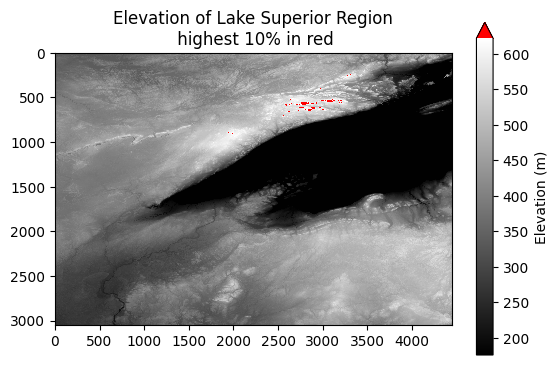

In [8]:
res = s.get(f'{api_url}/object/{dem_object_id}/raster', params=bbox)

with rasterio.MemoryFile(res.content) as memfile:
    with memfile.open() as dataset:
        dem = dataset.read(1) # Read the first and only band of the DEM dataset to an array for processing and visualization

        palette = plt.cm.gray.copy() # import a pre-made matplotlib color palette
        palette.set_over('red', 1.0) # color values over a range defined below red. set_under is also available
        palette.set_bad('blue', 0.0) # color 'bad' values (those defined by a mask below) as blue, but set opacity to 0.0 so they are transparent

        # Values returned from the API will likely have a small nodata border
        # These values must be masked otherwise the minimum color bar value will be the nodata value
        dem = np.ma.masked_where(dem == dataset.nodata, dem)

        plt.imshow(dem,
                   interpolation='none',
                   cmap=palette,
                   norm=colors.Normalize(vmin=dem.min(), vmax=(dem.max()*0.90))) # Define the color bar max as 90% of the max value to highlight the highest area
        plt.grid(False)
        plt.title('Elevation of Lake Superior Region\n highest 10% in red')
        plt.colorbar(label='Elevation (m)', extend='max', spacing='proportional', shrink=0.9)

    plt.show()

## Calculate statistics within a bounding box
Returns cell count, sum, mean, standard deviation, minimum, and maximum. Not all statistics will be relevant for all datasets, but all are calculated.

In [9]:
res = s.get(f'{api_url}/object/{dem_object_id}/stats', params=bbox)
bbox_stats = res.json()
display(pd.json_normalize(bbox_stats))

,count,sum,mean,stddev,min,max
0,13549756,4.975320e+09,367.188908,112.782818,176.0,691.0


## Calculate statistics within a polygon

In [10]:
# Define or import a geoJSON file
aoi = {"type": "Polygon", "coordinates":
     [[[-90.86257188625456, 46.88471631149375],
       [-90.21090204846868, 47.84867191684921],
       [-90.13229204839561, 47.986461643867216],
       [-91.31830244956424, 47.81423854488315],
       [-91.43583296326011, 47.408369403885246],
       [-92.38327281856216, 46.879798020360425],
       [-91.9971011307051, 46.54594590211718],
       [-90.86257188625456, 46.88471631149375]]]}

res = s.post(f'{api_url}/object/{slope_object_id}/stats', json=aoi)
aoi_stats = res.json()
display(pd.json_normalize(aoi_stats))

# or access the mean directly
print('Slope mean:', round(aoi_stats['mean'], 2))

,count,sum,mean,stddev,min,max
0,1187956,2.836843e+06,2.388004,3.744926,0.0,57.950825


Slope mean: 2.39
